In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime

#import gspread as gs

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [160]:
df=pd.read_excel(r'C:\Users\bantenuc\OneDrive - Ternium\Escritorio\BRUNO\Tesis\PDB.xlsx', sheet_name=0) #sheet_name=0 brings first sheet, =1 brings 2nd sheet
df = df.dropna() #is it ok to drop NaN values
df=df.reset_index()
df = df.drop('index', axis=1)
#df=df.set_index('Date')
df

,Q,Date,EV,TotEq,Cash,PrefEq,Debt,PX_LAST,MktCap,ShOu,EBITDA,EBITDA12m
0,3Q2007,2007-09-28,13311.8000,6139.200,1078.800,1857.300,4133.800,31.40,6294.8932,267.5000,318.400,1603.111
1,4Q2007,2007-10-01,13311.8000,6139.200,1078.800,1857.300,4133.800,31.77,6369.0686,267.5000,318.400,1603.111
2,4Q2007,2007-10-02,13311.8000,6139.200,1078.800,1857.300,4133.800,31.67,6349.0212,267.5000,318.400,1603.111
3,4Q2007,2007-10-03,13311.8000,6139.200,1078.800,1857.300,4133.800,31.46,6306.9216,267.5000,318.400,1603.111
4,4Q2007,2007-10-04,13311.8000,6139.200,1078.800,1857.300,4133.800,31.27,6268.8315,267.5000,318.400,1603.111
...,...,...,...,...,...,...,...,...,...,...,...,...
3770,3Q2022,2022-09-26,8448.1067,13704.000,2059.000,1928.000,1344.000,26.75,5362.6887,200.4740,1224.000,5817.824
3771,3Q2022,2022-09-27,8448.1067,13704.000,2059.000,1928.000,1344.000,27.35,5482.9733,200.4740,1224.000,5817.824
3772,3Q2022,2022-09-28,8448.1067,13704.000,2059.000,1928.000,1344.000,27.47,5507.0302,200.4740,1224.000,5817.824
3773,3Q2022,2022-09-29,8448.1067,13704.000,2059.000,1928.000,1344.000,27.23,5458.9164,200.4740,1224.000,5817.824


In [156]:
#Choose the rows that satisfy a condition and create a new df.
#quarter_df = df.loc[df['Q'] =='4Q2007']
#quarter_df

In [161]:
#Date commands
df['Date'] = pd.to_datetime(df.Date) #convert the date string into date object
#df.Date.dt.day_name() -> brings the name of the dayweek
df.dtypes

Q                    object
Date         datetime64[ns]
EV                  float64
TotEq               float64
Cash                float64
PrefEq              float64
Debt                float64
PX_LAST             float64
MktCap              float64
ShOu                float64
EBITDA              float64
EBITDA12m           float64
dtype: object

In [82]:
dates = ['31-03-2000','30-06-2000','30-09-2000','31-12-2000',
        '31-03-2001','30-06-2001','30-09-2001','31-12-2001',
        '31-03-2002','30-06-2002','30-09-2002','31-12-2002',
        '31-03-2003','30-06-2003','30-09-2003','31-12-2003',
        '31-03-2004','30-06-2004','30-09-2004','31-12-2004',
        '31-03-2005','30-06-2005','30-09-2005','31-12-2005',
        '31-03-2006','30-06-2006','30-09-2006','31-12-2006']

In [146]:
#Mean of a column

#df.PX_LAST.mean()

26.737023337748393

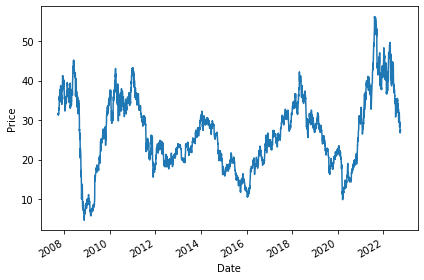

In [162]:
# Plot the time series
fig, ax = plt.subplots()

ax.plot(df.Date,df['PX_LAST'])
ax.set_xlabel('Date')
ax.set_ylabel('Price')


fig.autofmt_xdate()
plt.tight_layout()

In [163]:
#Check for stationarity - ADF is not a large negative number and p-value is greater than 0.05
target = df['PX_LAST']
ADF_result = adfuller(target)
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.8868230058348776
p-value: 0.046901899904165066


In [181]:
#Take first difference and check for stationarity

df['PXdiff'] = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -13.644769626501713
p-value: 1.6275128454061742e-25


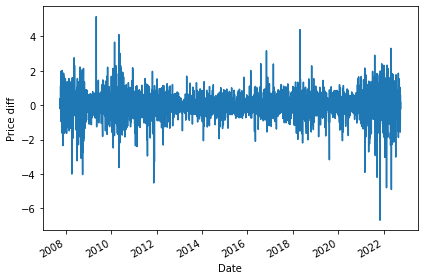

In [183]:
#Plot differenced series
fig, ax = plt.subplots()

ax.plot(df.Date,df.PXdiff)
ax.set_xlabel('Date')
ax.set_ylabel('Price diff')


fig.autofmt_xdate()
plt.tight_layout()

In [182]:
df.head()

,Q,Date,EV,TotEq,Cash,PrefEq,Debt,PX_LAST,MktCap,ShOu,EBITDA,EBITDA12m,PXdiff
0,3Q2007,2007-09-28,13311.8,6139.2,1078.8,1857.3,4133.8,31.40,6294.8932,267.5,318.4,1603.111,NaN
1,4Q2007,2007-10-01,13311.8,6139.2,1078.8,1857.3,4133.8,31.77,6369.0686,267.5,318.4,1603.111,0.37
2,4Q2007,2007-10-02,13311.8,6139.2,1078.8,1857.3,4133.8,31.67,6349.0212,267.5,318.4,1603.111,-0.10
3,4Q2007,2007-10-03,13311.8,6139.2,1078.8,1857.3,4133.8,31.46,6306.9216,267.5,318.4,1603.111,-0.21
4,4Q2007,2007-10-04,13311.8,6139.2,1078.8,1857.3,4133.8,31.27,6268.8315,267.5,318.4,1603.111,-0.19


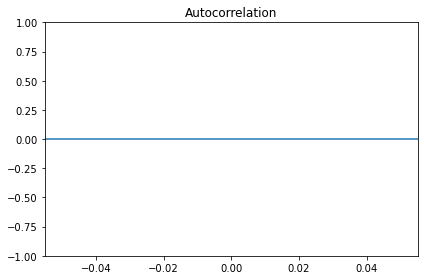

In [224]:
#Plot ACF for differenced series.

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.PXdiff, lags=30); 
plt.tight_layout() #If there is autocorrelation, means that is not an MA process

In [188]:
df_diff = pd.DataFrame(df.PXdiff)

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

3397
378


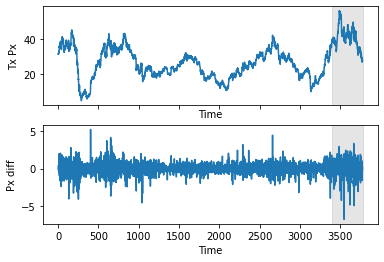

In [189]:
#Graph and highlight the test set

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['PX_LAST'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Tx Px')
ax1.axvspan(len(train), len(train)+len(test), color='#808080', alpha=0.2)

ax2.plot(df_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Px diff')
ax2.axvspan(len(train), len(train)+len(test), color='#808080', alpha=0.2)

In [222]:
# def the models. Mean - Last Price - MA.
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':#NOT RUNNING
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,4))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [223]:
#Save the results. Check what happened with the mean value.
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()
# Where is it calling PX_LAST to the differenced series. Why mean is not calculating? (Bc of NaN values on Dataset??)

,PXdiff,pred_mean,pred_last_value,pred_MA
3397,0.86,NaN,0.23,-0.056870
3398,-0.23,NaN,0.23,0.010215
3399,-0.30,NaN,-0.23,0.012398
3400,-0.48,NaN,-0.23,-0.044091
3401,-0.36,NaN,-0.48,-0.014871


In [199]:
pred_df

,PXdiff,pred_mean,pred_last_value
3397,0.86,-0.008244,0.23
3398,-0.23,0.005188,0.23
3399,-0.30,0.016251,-0.23
3400,-0.48,-0.006130,-0.23
3401,-0.36,-0.016782,-0.48
...,...,...,...
3770,-1.13,0.002218,0.52
3771,0.60,-0.050527,-1.13
3772,0.12,-0.004230,-1.13
3773,-0.24,0.006179,0.12


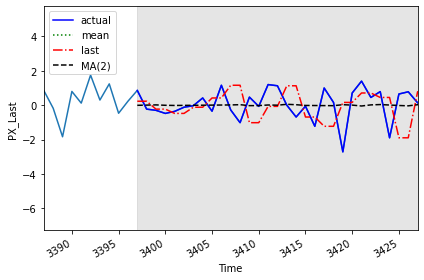

In [220]:
# Plot all results. Don't know why other results are not showing up

fig, ax = plt.subplots()

ax.plot(df_diff['PXdiff'])
ax.plot(pred_df['PXdiff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('PX_Last')

ax.axvspan(len(train), len(train)+30, color='#808080', alpha=0.2)

ax.set_xlim(len(train)-10, len(train)+30)



fig.autofmt_xdate()
plt.tight_layout()

In [221]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['PXdiff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['PXdiff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').